## Two dimensions

To start thinking about 2 dimensions, we can tackle a modified version of the Lighthouse problem.

Lighthouse problem:
* [Example 1](http://www.di.fc.ul.pt/~jpn/r/bugs/lighthouse.html)
* [Example 2](https://alexjbrinson.github.io/LightHouse/)
* [Example 3](https://www.mjoldfield.com/atelier/2017/10/gulls-lighthouse.html)

In this version, we imagine you are playing paintball in a walled 30x50m area, with various objects in the area that can be used as cover (for hiding behind). You are standing by one of the 30m walls and an opponent is firing at you, leaving platters along the wall behind you.

The splatters are at 15, 16, 18 and 21m (from the lower left corner of the room). From these data, can we estimate where our opponent is hiding?

We can start this problem by creating a Suite that represents a number of hypotheses about the location of my opponent as a pair of coordinates: (alpha, beta).

The Paintball class inherits from Suite and Joint.

*alpha* and *beta* are lists of possible values, and *pairs* gives a list of all combined pairs.

*locations* gives all possible locations along the wall and will be used by Likelihood.



In [31]:
import thinkbayes
import math
import matplotlib.pyplot as plt
import numpy as np

class Paintball(thinkbayes.Suite, thinkbayes.Joint):
    
    def __init__(self, alphas, betas, locations):
        self.locations = locations
        pairs = [(alpha, beta)
                 for alpha in alphas
                 for beta in betas]
        thinkbayes.Suite.__init__(self, pairs)
        
    def Likelihood(self, data, hypo):
        alpha, beta = hypo
        x = data
        pmf = MakeLocationPmf(alpha, beta, self.locations)
        like = pmf.Prob(x)
        return like

# Set up values based on rooms size, prior distribution assumes all locations in room are equally likely.
alphas = range(0, 31)
betas = range(1, 51)
locations = range(0,31)


def StrafingSpeed(alpha, beta, x):
    theta = math.atan2(x - alpha, beta)
    speed = beta / math.cos(theta) ** 2
    return speed

def MakeLocationPmf(alpha, beta, location):
    pmf = thinkbayes.Pmf()
    for x in locations:
        prob = 1.0 / StrafingSpeed(alpha, beta, x)
        pmf.Set(x, prob)
        
    pmf.Normalize()
    return pmf

suite = Paintball(alphas, betas, locations)
suite.UpdateSet([15, 16, 18, 21])

1.9032915958109017e-06

### Trigonometry

Our likelihood function specifies how likely it is to hit any given spot along the wall, given the location of the opponent. 

If we assume the opponent is a rotating turret which is equally likely to shoot in any direction and $\alpha$ is the point on the wall closest to the shooter (the adjacent side of the triangle) then it is more likely that the shooter will hit parts of the wall closer to $\alpha$ than further away.

We can use trigonometry to compute the likelihood of hitting a spot along the wall, $x$, which is at angle $\theta$

$x - \alpha = \beta tan \theta$

Solving for $\theta$

$\theta = tan^{-1}\left( \frac{x-\alpha}{\beta}\right)$

So given a spot on the wall we can find $\theta$, then taking derivative of first equation wrt $\theta$:

$\frac{dx}{d\theta} = \frac{\beta}{cos^2\theta}$

We can refer to this as the *strafing speed*, speed of target on wall as $\theta$ increases. Probability of hitting a point on wall is inversely proportional to strafing speed (assuming steady rate of firing).

Using a function for strafing speed, we can them compute a Pmf that represents the probability of hitting any location on the wall (MakeLocationPmf).

Then we can use this to compute our likelihood.

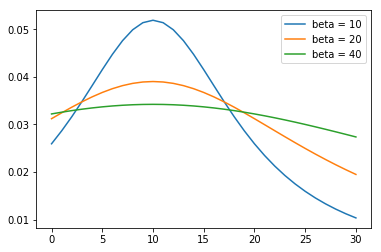

In [3]:
def MakePmfPlot(alpha = 10, betas = [10, 20, 40], locations = range(0,31)):

    for beta in betas:
        pmf = MakeLocationPmf(alpha, beta, locations)
        pmf.name = 'beta = %d' % beta
        
        location_vals, prob_vals = [[x[i] for x in pmf.Items()] for i in (0,1)]
        plt.plot(location_vals, prob_vals, label=pmf.name)
        
    plt.legend()
    plt.show()
    
MakePmfPlot()

### Joint distributions

When each value in a distribution is a tuple of variables, it's referred to as a **joint distribution** because it represents distributions of variables together.

The joint distribution contains distributions of the variables as well as information about the relationships between each variable.

**Marginal distributions** can be computed from a joint distribution, which give the distribution of each variable independently.

In [4]:
## From the Joint class

def Marginal(self, i):
    pmf = Pmf()
    for vs, prob in self.Items():
        pmf.Incr(vs[i], prob)
    return pmf

marginal_alpha = suite.Marginal(0)
marginal_beta = suite.Marginal(1)

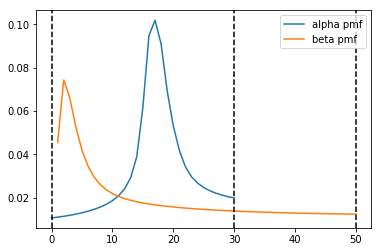

In [15]:
alpha_location_vals, alpha_prob_vals = [[x[i] for x in marginal_alpha.Items()] for i in (0,1)]
plt.plot(alpha_location_vals, alpha_prob_vals, label='alpha pmf')


beta_location_vals, beta_prob_vals = [[x[i] for x in marginal_beta.Items()] for i in (0,1)]
plt.plot(beta_location_vals, beta_prob_vals, label='beta pmf')

for x in [0, 30, 50]:
    plt.axvline(x, color = 'k', ls='--')

plt.legend()
plt.show()

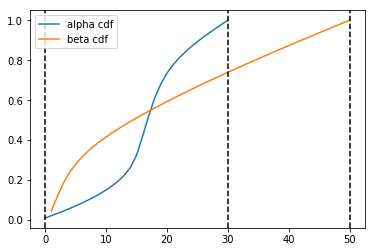

In [16]:
marginal_alpha_cdf = thinkbayes.MakeCdfFromPmf(marginal_alpha)
marginal_beta_cdf = thinkbayes.MakeCdfFromPmf(marginal_beta)

alpha_location_vals, alpha_prob_vals = [[x[i] for x in marginal_alpha_cdf.Items()] for i in (0,1)]
plt.plot(alpha_location_vals, alpha_prob_vals, label='alpha cdf')


beta_location_vals, beta_prob_vals = [[x[i] for x in marginal_beta_cdf.Items()] for i in (0,1)]
plt.plot(beta_location_vals, beta_prob_vals, label='beta cdf')

for x in [0, 30, 50]:
    plt.axvline(x, color = 'k', ls='--')

plt.legend()
plt.show()

### Conditional distributions

Marginal distributions do not capture the dependence between variables.

One way to visualise dependence is by computing the **condition distribution**.

Given two variables with potential values i and j, we can iterate through i and j to get the distribution of the ith variable under the condition that jth variable is a given value.

Can compute distributions for alpha for a series of beta values, which we refer to as *posterior conditional marginal distributions*.

If variables were independent then the conditional distributions would be the same. As they are different we know the variables are dependent.

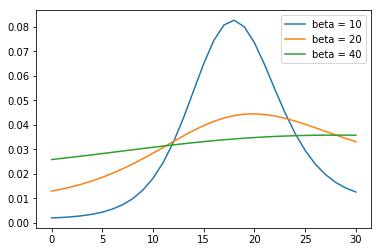

In [19]:
betas = [10, 20, 40]

for beta in betas:
    cond = suite.Conditional(0,1, beta)
    
    location_vals, prob_vals = [[x[i] for x in cond.Items()] for i in (0,1)]
    plt.plot(location_vals, prob_vals, label=f'beta = {beta}')
        
plt.legend()
plt.show()

### Credible intervals

Another way to visualise posterior joint distribution is to compute credible intervals. For a given distribution, there are many intervals on the same level of credibility (e.g. for a 50% credible interval you can choose any set of values whose probability adds up to 50%).

For one-dimensional values, common to choose the **central credible interval**. Central 50% CI contains all values between the 25th and 75th percentiles.

In multi dimensional case it's not as obvious. Best choice varies but common choice is the maximum likelihood credible interval, containing most likely values that add up to your desired percentage.

We can plot the 25%, 50% and 75% credible intervals for our paintball problem to visualise likely areas for the opponent.

In [22]:
def MakeCrediblePlots(suite):
    d = dict((pair, 0) for pair in suite.Values())
    
    percentages = [75, 50, 25]
    for p in percentages:
        interval = suite.MaxLikeInterval(p)
        for pair in interval:
            d[pair] += 1
            
    return d

cred_suite = MakeCrediblePlots(suite)

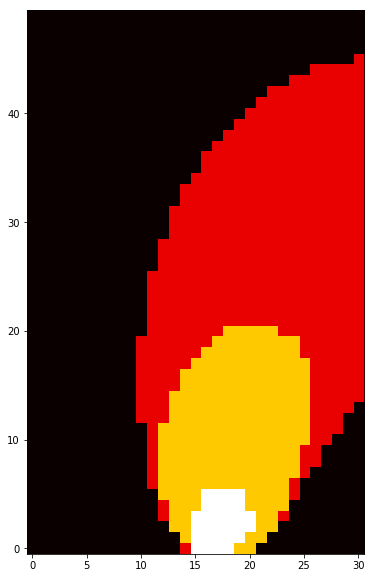

In [53]:
plot_suite = np.array(list(cred_suite.values())).reshape((31,50)).T
plt.figure(figsize=(15,10))
plt.imshow(plot_suite, cmap='hot', origin='lower')
plt.show()

### Discussion

Recap of definitions introduced in this chapter:

**Joint distribution** is a distribution that represents all possible values in a multidimensional space and their probabilities.

**Maginal distributions** are distributions for one parameter in a joint distribution, treating the other parameters as unknown.

**Conditional distribution** is the distribution of one parameter in a joint distribution, conditioned on one or more of the other parameters.

Given the joint distribution, you can compute marginal and condition distributions. With enough conditional distributions you could recreate or approximate the join distribution. But marginal distributions do not give you enough information to recreate the join distribution.

If there are $d$ parameters, with $n$ possible values each then the run time is proportional to $n^d$. This becomes impractical as $d$ increases. Optimisations will be discussed in chapter 15.

